In [1]:
import matplotlib.pyplot as plt
import matplotlib.font_manager as fm
import matplotlib.gridspec as gridspec  # Ensure this import is included
from matplotlib import rcParams
from highlight_text import fig_text
import pandas as pd

from PIL import Image
import urllib
import os

In [2]:
# --- Read and transform the data

df = pd.read_csv('C:/Users/jeffr/OneDrive/Desktop/Github Activities/Sports_Analysis/Football/07 Matchday Shot Viz/Data/matchday_shots.csv', index_col = 0)
df['min'] = df['min'].astype(int)
df['xG'] = df['xG'].astype(float)
# Rename PSG 
df = df.replace({
    'teamName': {
        'Paris Saint-Germain': 'PSG'
    }
})

In [3]:
df.head(10)

,teamId,playerId,playerName,min,xG,eventType,teamColor,isOwnGoal,teamName,venue,match_id
1,9879,493647,Adama Traoré,8,0.030144,Miss,#000000,False,Fulham,A,4506263
2,9879,469804,Kenny Tete,13,0.019572,AttemptSaved,#000000,False,Fulham,A,4506263
3,9879,1128945,Rodrigo Muniz,14,0.050167,AttemptSaved,#000000,False,Fulham,A,4506263
4,10260,422685,Bruno Fernandes,20,0.020179,Miss,#C70101,False,Manchester United,H,4506263
5,10260,208494,Casemiro,27,0.042184,Miss,#C70101,False,Manchester United,H,4506263
6,10260,422685,Bruno Fernandes,29,0.251960,AttemptSaved,#C70101,False,Manchester United,H,4506263
7,10260,422685,Bruno Fernandes,34,0.687684,AttemptSaved,#C70101,False,Manchester United,H,4506263
8,10260,208494,Casemiro,37,0.074945,Miss,#C70101,False,Manchester United,H,4506263
9,10260,208494,Casemiro,42,0.045642,Miss,#C70101,False,Manchester United,H,4506263
10,9879,604785,Alex Iwobi,48,0.039298,Miss,#000000,False,Fulham,A,4506263


In [4]:
# Function to plot the xG match axes
def plot_axes_xg_by_match(ax, fig, match_id, data=df):
    df = data.copy()
    match_df = df[df['match_id'] == match_id].reset_index(drop=True)
    match_df.sort_values(by='min', ascending=True).reset_index(drop=True)

    home_conditional = (match_df['venue'] == 'H')
    away_conditional = (match_df['venue'] == 'A')

    # Clean up the axes
    ax.set_ylim(-1.05, 1.05)
    ax.set_xlim(-5, 95)
    ax.spines['left'].set_visible(False)
    ax.spines['right'].set_visible(False)
    ax.spines['top'].set_visible(False)
    ax.yaxis.set_ticks([])

    xticks = [x for x in range(-2, 45, 10)] + [x for x in range(52, 102, 10)]
    xlabels = [x for x in range(0, 91, 10)]

    ax.set_xticks(xticks)
    ax.set_xticklabels(xlabels)

    ax.tick_params(labelsize=7)
    plt.rcParams['hatch.linewidth'] = 0.45

    home_color = match_df[home_conditional]['teamColor'].iloc[0]
    away_color = match_df[away_conditional]['teamColor'].iloc[0]

    # Plot home shots
    for index, shot in enumerate(match_df[home_conditional]['xG']):
        ec_ = home_color
        marker = 'o'
        minute = match_df[home_conditional]['min'].iloc[index]
        offset_x = -2 if minute < 46 else 2
        hatch = ''
        if match_df[home_conditional]['eventType'].iloc[index] == 'Goal':
            hatch = '/////////////'
            if match_df[home_conditional]['isOwnGoal'].iloc[index]:
                shot = -1 * shot
                ec_ = away_color
                marker = '^'
        ax.scatter([minute + offset_x], [shot + .025], marker=marker, s=40, hatch=hatch,
                   color="white", zorder=3, lw=1.15, ec=ec_)
        ax.plot([minute + offset_x, minute + offset_x], [0, shot], color=ec_, zorder=2)

    # Plot away shots
    for index, shot in enumerate(match_df[away_conditional]['xG']):
        ec_ = away_color
        marker = 'o'
        minute = match_df[away_conditional]['min'].iloc[index]
        offset_x = -2 if minute < 46 else 2
        hatch = ''
        if match_df[away_conditional]['eventType'].iloc[index] == 'Goal':
            hatch = '/////////////'
            if match_df[away_conditional]['isOwnGoal'].iloc[index]:
                shot = -1 * shot
                ec_ = home_color
                marker = 'v'
        ax.scatter([minute + offset_x], [-1 * shot - .025], marker=marker, s=40, hatch=hatch,
                   color="white", zorder=3, lw=1.15, ec=ec_)
        ax.plot([minute + offset_x, minute + offset_x], [0, -1 * shot], color=ec_, zorder=2)

    # --- Make it pretty ---
    ax.plot([-5, 95], [0, 0], color='black', lw=1.75)
    ax.plot([45, 45], [-1.05, 1.05], color='white', lw=1.75, zorder=2)
    ax.fill_between(x=[-5, 95], y1=[0], y2=[1.05], color=home_color, alpha=0.1, zorder=1, hatch=".......")
    ax.fill_between(x=[-5, 95], y1=[0], y2=[-1.05], color=away_color, alpha=0.1, zorder=1, hatch=".......")

    # --- Add the logos and legend ---
    home_team_id = match_df[home_conditional]['teamId'].iloc[0]
    away_team_id = match_df[away_conditional]['teamId'].iloc[0]
    home_team_name = match_df[home_conditional]['teamName'].iloc[0]
    away_team_name = match_df[away_conditional]['teamName'].iloc[0]

    DC_to_FC = ax.transData.transform
    FC_to_NFC = fig.transFigure.inverted().transform
    DC_to_NFC = lambda x: FC_to_NFC(DC_to_FC(x))

    fotmob_url = 'https://images.fotmob.com/image_resources/logo/teamlogo/'

    ax_coords = DC_to_NFC([-2, .55])
    logo_ax = fig.add_axes([ax_coords[0], ax_coords[1], 0.03, 0.03], anchor='W')
    club_icon = Image.open(urllib.request.urlopen(f'{fotmob_url}{home_team_id:.0f}.png')).convert("LA")
    logo_ax.imshow(club_icon)
    logo_ax.axis('off')

    ax_coords = DC_to_NFC([-2, -.9])
    logo_ax = fig.add_axes([ax_coords[0], ax_coords[1], 0.03, 0.03], anchor='W')
    club_icon = Image.open(urllib.request.urlopen(f'{fotmob_url}{away_team_id:.0f}.png')).convert("LA")
    logo_ax.imshow(club_icon)
    logo_ax.axis('off')

    # --- Compute goals and xG
    home_xG = match_df[home_conditional & (match_df['isOwnGoal'] == False)]['xG'].sum()
    away_xG = match_df[away_conditional & (match_df['isOwnGoal'] == False)]['xG'].sum()
    home_goals = (match_df[home_conditional & (match_df['isOwnGoal'] == False)]['eventType'] == 'Goal').sum() + (
            match_df[away_conditional & (match_df['isOwnGoal'] == True)]['eventType'] == 'Goal').sum()
    away_goals = (match_df[away_conditional & (match_df['isOwnGoal'] == False)]['eventType'] == 'Goal').sum() + (
            match_df[home_conditional & (match_df['isOwnGoal'] == True)]['eventType'] == 'Goal').sum()

    ax.annotate(
        s=f'{home_team_name} ({home_xG:.1f}) vs. {away_team_name} ({away_xG:.1f}):\n{home_goals} - {away_goals}',
        xy=(0.02, 1.05),
        xycoords='axes fraction',
        weight='bold',
        size=5
    )

    return ax

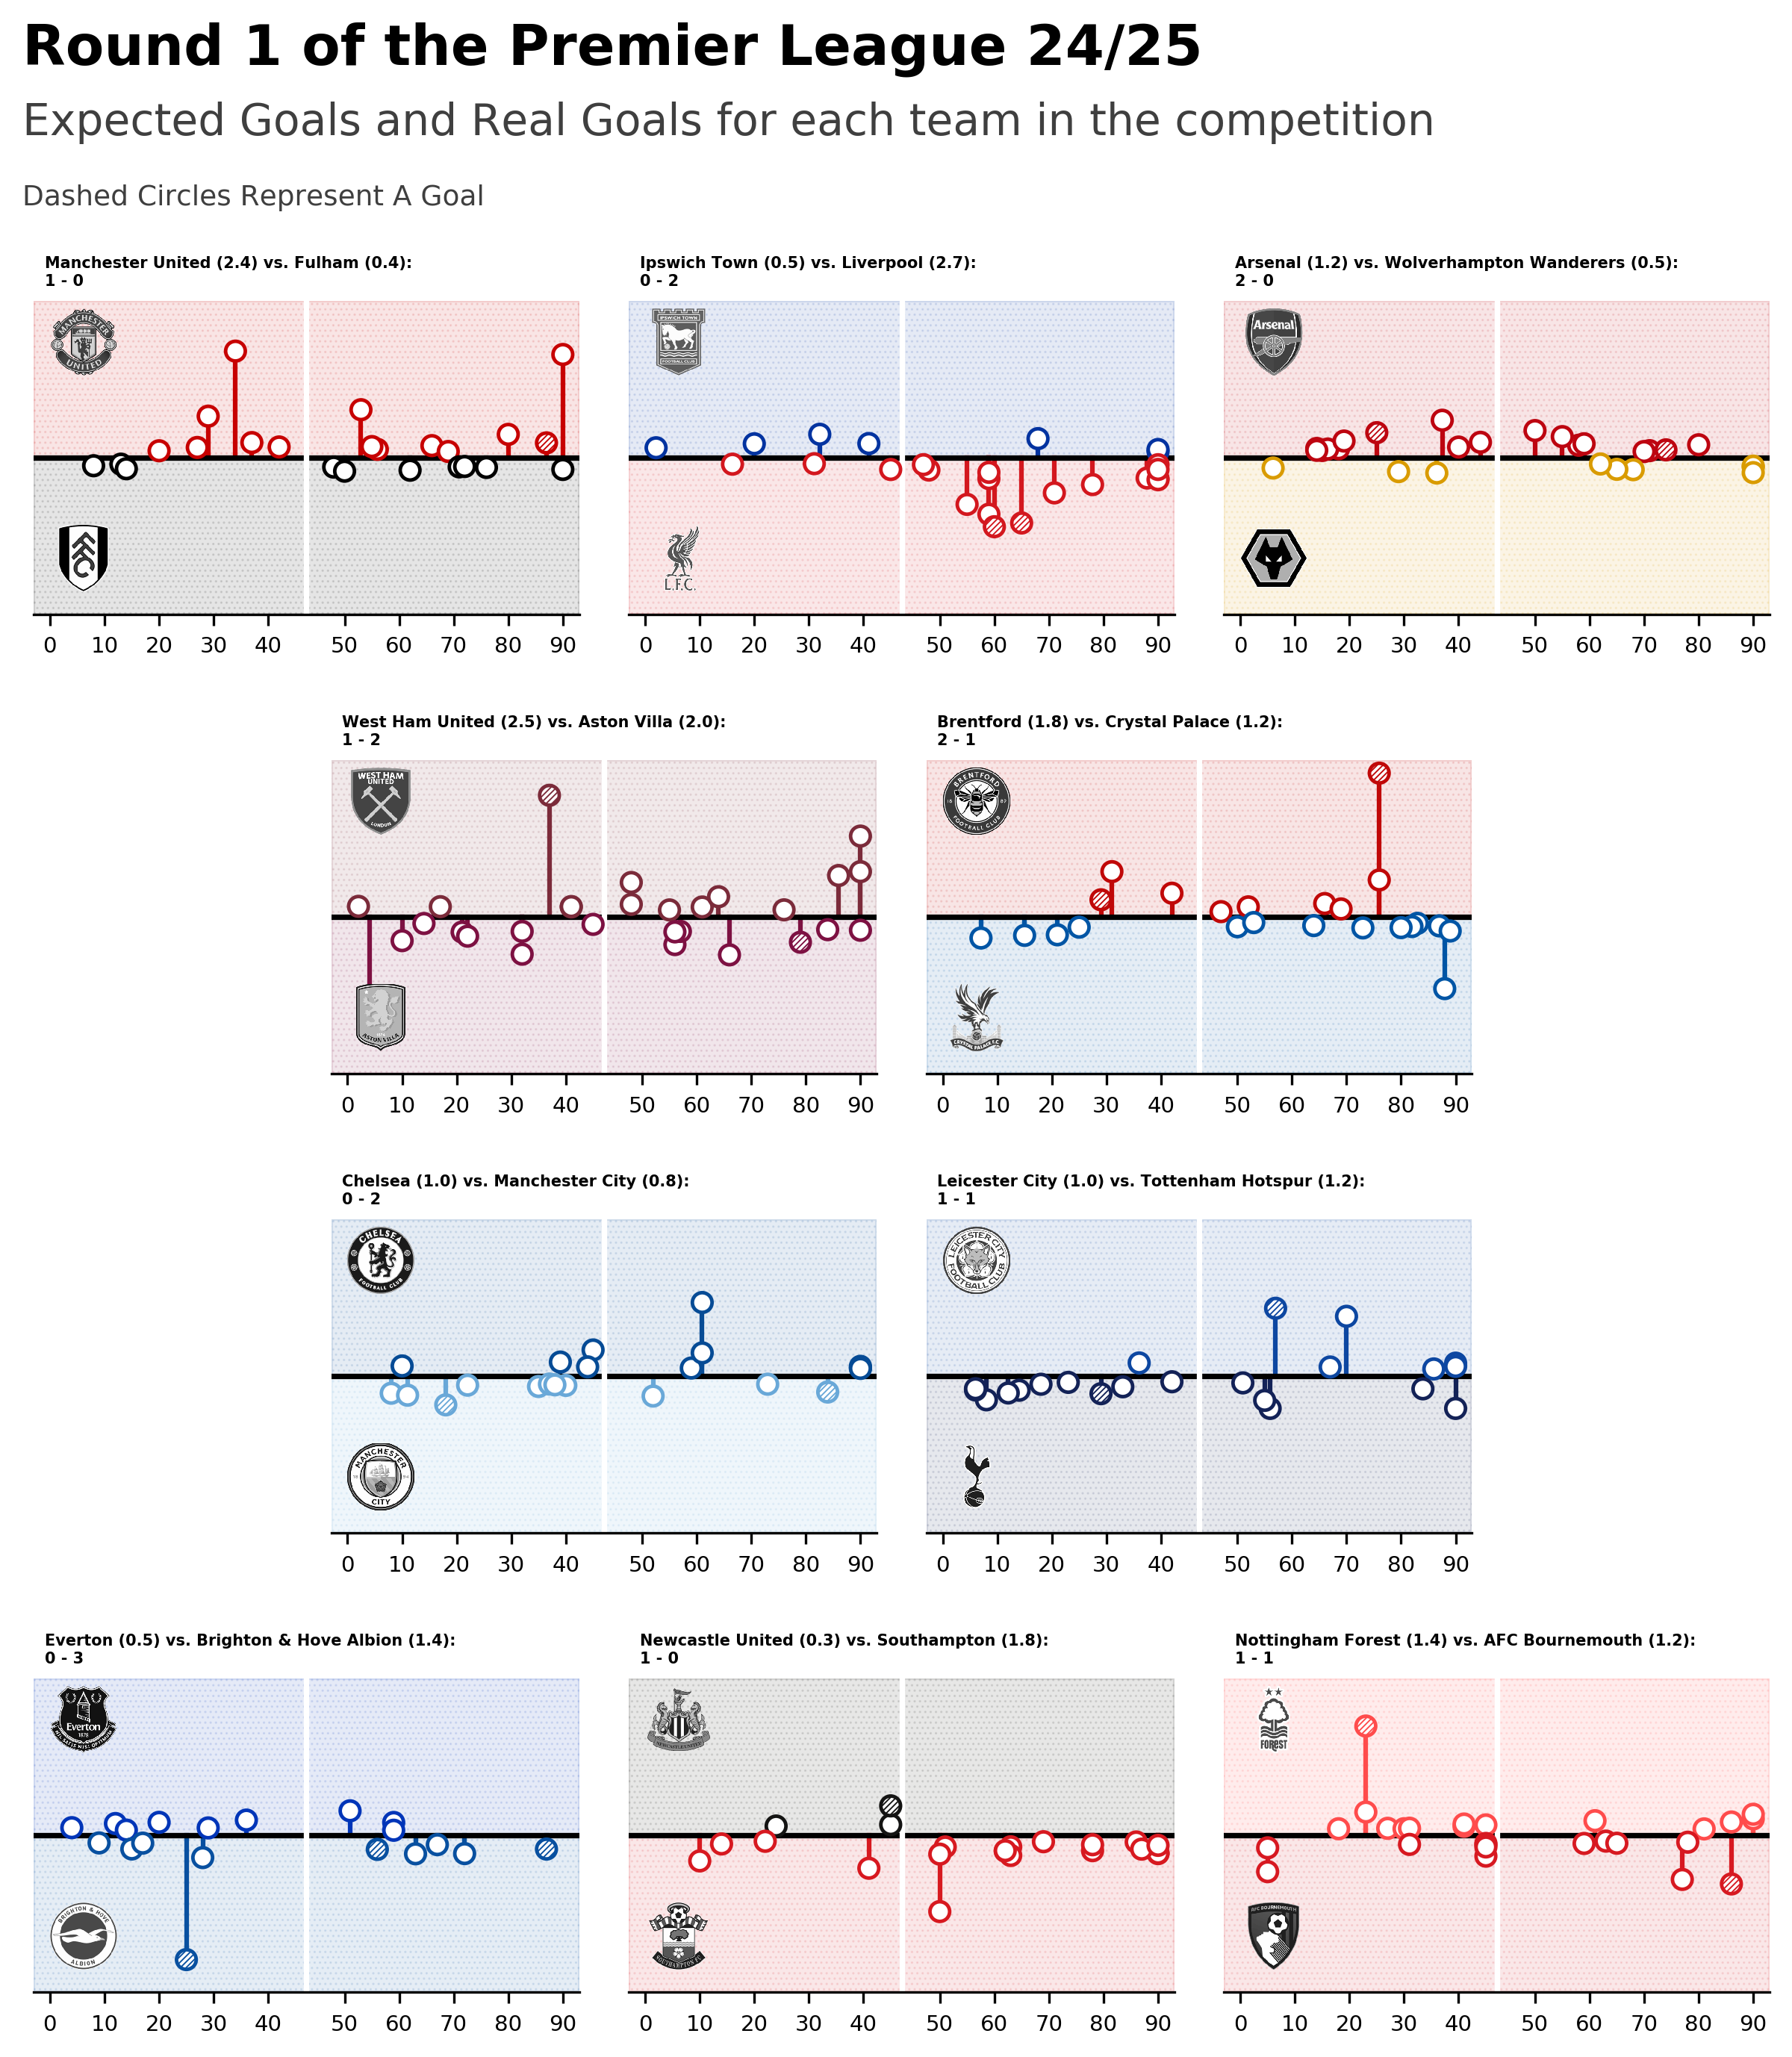

In [6]:
# --- The Final Visual ---
f = plt.figure(figsize=(10, 10), dpi=300)
gs = gridspec.GridSpec(7, 6, figure=f, height_ratios=[1, .05, 1, .05, 1, .05, 1], hspace=0.35)

# Mapping layout to GridSpec
layout_map = {
    'A': gs[0, 0:2], 'B': gs[0, 2:4], 'C': gs[0, 4:6],
    'D': gs[6, 0:2], 'E': gs[6, 2:4], 'F': gs[6, 4:6],
    'G': gs[2, 1:3], 'H': gs[2, 3:5],
    'I': gs[4, 1:3], 'J': gs[4, 3:5],
}

counter = 0
df = df.sort_values(by='match_id').reset_index(drop=True)
matches = list(df['match_id'].unique())

for k, gs_item in layout_map.items():
    ax = f.add_subplot(gs_item)
    match_id = matches[counter]
    plot_axes_xg_by_match(ax, f, match_id=match_id, data=df)
    counter += 1

# Adding the main title and subtitle
f.text(0.12, 0.98, "Round 1 of the Premier League 24/25", va="bottom", ha="left", fontsize=18, color="black", weight="bold")
f.text(0.12, 0.95, "Expected Goals and Real Goals for each team in the competition", va="bottom", ha="left", fontsize=14, color="black", alpha=0.75)
f.text(0.12, 0.92, "Dashed Circles Represent A Goal", va="bottom", ha="left", fontsize=9, color="black", alpha=0.75)

#plt.show()

plt.savefig(
	"C:/Users/jeffr/OneDrive/Desktop/Github Activities/Sports_Analysis/Football/07 Matchday Shot Viz/Figures/Round 1 Premier League.png",
	dpi = 600,
	facecolor = "#EFE9E6",
	bbox_inches="tight",
    edgecolor="none",
	transparent = False
)